In [2]:
# !pip install scikeras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# from scikeras.wrappers import KerasClassifier

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping



## Import Data

In [19]:
data = pd.read_csv('./data/classification_data.csv')
data.head(2)

,MonthOccurrence,TotalNumberOfVictims,TotalNumberOfIndividualVictims,SuspectsRaceAsAGroup,TotalNumberOfSuspects,MostSeriousUcr,MostSeriousUcrType,MostSeriousLocation,MostSeriousBias,MostSeriousBiasType,MostSeriousVictimType,WeaponType,Offensive_Act,labels
0,2,2,2,Unknown,0,Intimidation,Violent Crimes,Residence/Home/Driveway,Anti-Black or African American,Race/Ethnicity/Ancestry,Person,None,Daubing of swastika,1
1,3,1,1,White,1,Destruction/Damage/Vandalism,Property Crimes,Residence/Home/Driveway,Anti-Asian,Race/Ethnicity/Ancestry,Person,None,Threatening letters/flyers/email,1


## Transform and Scale Data

### Column Transformer

In [20]:
X = data.drop(columns=['labels'])
ct = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
    remainder='passthrough',
    verbose_feature_names_out=False
)
X_encoded = ct.fit_transform(X)
X_encoded
ct.get_feature_names_out()
X_encoded = pd.DataFrame(X_encoded, columns=ct.get_feature_names_out())

X_encoded.head(2)

,SuspectsRaceAsAGroup_American Indian or Alaska Native,SuspectsRaceAsAGroup_Asian,SuspectsRaceAsAGroup_Asian/Pacific Islander,SuspectsRaceAsAGroup_Black or African American,SuspectsRaceAsAGroup_East Indian/Asian Indian,SuspectsRaceAsAGroup_Group of Multiple Races,SuspectsRaceAsAGroup_Hispanic,SuspectsRaceAsAGroup_Native Hawaiian or Other Pacific Islander,SuspectsRaceAsAGroup_Unknown,SuspectsRaceAsAGroup_White,...,Offensive_Act_Hanging in Effigy,Offensive_Act_Other,Offensive_Act_Rock throwing,Offensive_Act_Threatening letters/flyers/email,Offensive_Act_Unknown,Offensive_Act_Verbal slurs,MonthOccurrence,TotalNumberOfVictims,TotalNumberOfIndividualVictims,TotalNumberOfSuspects
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.0,1.0


### Scaling

In [21]:
X_encoded_scaled = StandardScaler().fit_transform(X_encoded)

## Target

In [23]:
y = data['labels']

y_categorical = to_categorical(y, 3)

## Baseline

In [24]:
y.value_counts(normalize=True)

1    0.734875
0    0.160368
2    0.104757
Name: labels, dtype: float64

## Test/Train Split


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded_scaled, y_categorical, stratify=y, random_state=13)

X_train.shape

y_train.shape

(14268, 3)

## Random Forest

In [27]:
rf = RandomForestClassifier(n_jobs=-1)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.673954172797982

### Confusion Matrix Display

In [28]:
y_preds = rf.predict(X_test)

''

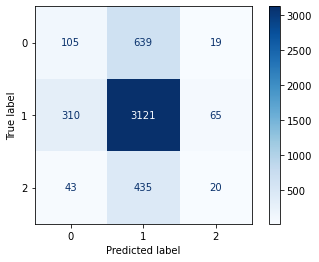

In [30]:
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), np.rint(y_preds).argmax(axis=1), cmap='Blues')
;

### Balanced Accuracy Score

In [31]:
balanced_accuracy_score(y_test.argmax(axis=1), y_preds.argmax(axis=1))

0.3568366250817025

## Extra Trees

In [32]:
et = ExtraTreesClassifier(n_jobs=-1)
et.fit(X_train, y_train)
et.score(X_test, y_test)

0.647887323943662

### Confusion Matrix Display

In [33]:
y_preds = et.predict(X_test)

''

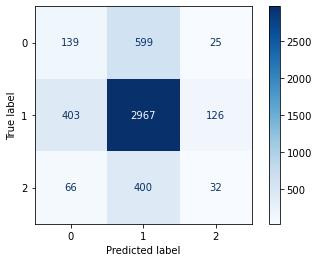

In [34]:
ConfusionMatrixDisplay.from_predictions(y_test.argmax(axis=1), np.rint(y_preds).argmax(axis=1), cmap='Blues')
;

### Balanced Accuracy Score

In [35]:
balanced_accuracy_score(y_test.argmax(axis=1), y_preds.argmax(axis=1))

0.36503895372712014

## RandomizedSearchCV on Extra Trees

### Extra Trees

In [36]:
et = ExtraTreesClassifier()

In [37]:
et.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [38]:
params = {
    'n_estimators': range(100, 1000)
}

### RandomizedSearchCV

In [39]:
rs = RandomizedSearchCV(
    et,
    params,
    n_jobs=-1
)

rs_result = rs.fit(X_train, y_train)

# Result summary
print(f"Best score: {rs_result.best_score_}. Used these parameters: {rs_result.best_params_}")

# This part copied from machine learning mastery prints out all results to check where improvements can be made
means = rs_result.cv_results_['mean_test_score']
stds = rs_result.cv_results_['std_test_score']
params = rs_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best score: 0.6362498222282155. Used these parameters: {'n_estimators': 387}
0.636250 (0.008164) with: {'n_estimators': 387}
0.635409 (0.009022) with: {'n_estimators': 425}
0.635969 (0.008417) with: {'n_estimators': 629}
0.635339 (0.008324) with: {'n_estimators': 992}
0.634988 (0.007465) with: {'n_estimators': 236}
0.635759 (0.007922) with: {'n_estimators': 942}
0.635198 (0.008139) with: {'n_estimators': 935}
0.631694 (0.007538) with: {'n_estimators': 212}
0.634428 (0.009646) with: {'n_estimators': 263}
0.635619 (0.008772) with: {'n_estimators': 493}


In [40]:
y_preds = rs_result.best_estimator_.predict(X_test)

In [41]:
balanced_accuracy_score(y_test.argmax(axis=1), y_preds.argmax(axis=1))

0.36707056830340684